In [1]:
import qutip as q
import numpy as np
import subprocess
import ffmpeg
import pickle
import os
import re

%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 18}
rc('font', **font)

from matplotlib.font_manager import FontProperties

Our final goal is to solve understand to solve this Hamiltonian for double quantum sensing

$H = D S_z^2 + \frac{\omega_0}{2}  \,S_z + \frac{\Omega_{rf}}{2}  \,cos(\omega_{rf}t) S_z  + \Omega_1 \, \cos(\omega_1 t) \, \sigma_x$

where $\omega_0$ is the magnetic field $\omega_0 = \gamma B$, $D$ is the zero field splitting, $\Omega_{rf}$ 
is the strength and $\omega_{rf}$ is the frequency of the strong longitudinal RF field, finally we have the 
control field $\Omega_1$ given the transitions between energy levels.

Firat we define the operators and verify all variables with FID/rabi oscillations

In [137]:
#resonance frequency D \pm ws
ws = 0.06e3
D = 2.8e3

def get_Hdc():
    Hdc = ws * sz + D*(sz**2)
    return Hdc

In [138]:
#Frequency
Omega = 1
Omega *= 2 * np.pi

# NV hamiltonian
sx = q.spin_Jx(1)
sy = q.spin_Jy(1)
sz = q.spin_Jz(1)



Hdc = get_Hdc()

#time list
time_x=2
t = np.linspace(0, time_x, 5000)

#initial state
a = 45
phi =np.cos(np.deg2rad(a))*q.basis(3,0) + np.sin(np.deg2rad(a))* q.basis(3,1)
rho_nv = phi*phi.dag()
rho_nv


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5 0.5 0. ]
 [0.5 0.5 0. ]
 [0.  0.  0. ]]

C:\Users\yy3\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


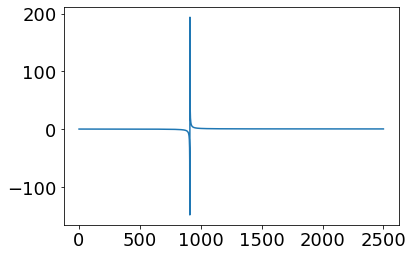

In [140]:
resultat = []
resultat.append(q.mesolve(H=Hdc, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))

data = q.expect(resultat[0].states, sx)

#plot Fourier of the FID
plt.plot(np.fft.rfft(data))

## Time dependant Hamiltonian

### First only Probe and 3LS - no Floquet

In [141]:


Omega = 0.01
Omegarf = 0.04

#time independant
Hdc = get_Hdc()

#time dependant
H1 = Omega * sx
Hrf = Omegarf * sz

#time dependant functions
def Hx1_coeff(t,args):
    freq = args['freq1']
    return np.sin(2 * np.pi *freq * t)



def Hxprobe_coeff(t,args):
    freq = args['freqp'] 
    phase = args['phasep']
    return np.sin(2 * np.pi *freq * t + phase)


#Overall Hamiltonian
H = [Hdc,[H1,Hxprobe_coeff]] #[Hrf,Hx1_coeff],
H

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[2860.    0.    0.]
  [   0.    0.    0.]
  [   0.    0. 2740.]],
 [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
  Qobj data =
  [[0.         0.00707107 0.        ]
   [0.00707107 0.         0.00707107]
   [0.         0.00707107 0.        ]],
  <function __main__.Hxprobe_coeff(t, args)>]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


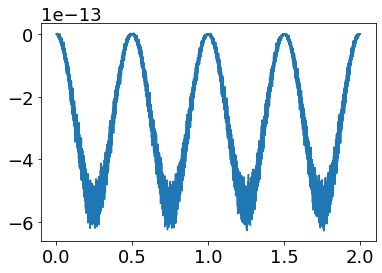

In [146]:
#initial state
phi = q.basis(3,1)
rho_nv = phi*phi.dag()
print(rho_nv)

startf = -2
stopf = 2

odmr_frq = []
odmr = []
length=10
wrf = 1
phase = 0

freqs  = np.linspace(startf,stopf,length)

for k in range(length):
    wodmr = freqs[k] + 2860
    odmr_frq.append(wodmr)
    output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                       options=q.Options(nsteps=100000), args={'freq1':wodmr ,'freqp': wrf, 'phasep': phase})
    odmr.append(q.expect(output.states, sz)[-1])
    
plt.plot(t,q.expect(output.states, sz))

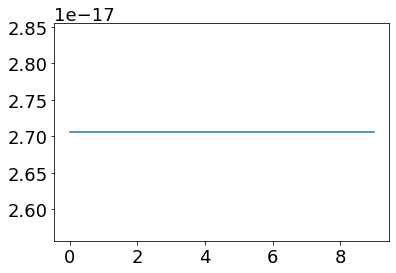

In [147]:
plt.plot(odmr)